In [1]:
import cv2
import os
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.utils.data as tud
import pdb
import random
import struct
import gzip

In [3]:
def judge(img):
    for i in range(15):
        img[0][i] = 255
        img[24][i] = 255
    for i in range(25):
        img[i][0] = 255
        img[i][14] = 255
    for x in range(23):
        x = x+1
        for y in range(13):
            y = y+1
            m = 0
            if(0 == img[x-1][y-1]):
                m = m+1
            if(0 == img[x-1][y]):
                m = m+1
            if(0 == img[x-1][y+1]):
                m = m+1
            if(0 == img[x][y-1]):
                m = m+1
            if(0 == img[x][y+1]):
                m = m+1
            if(0 == img[x+1][y-1]):
                m = m+1
            if(0 == img[x+1][y]):
                m = m+1
            if(0 == img[x+1][y+1]):
                m = m+1
            if m<3:
                img[x][y] = 255
    for x in range(23-1,-1,-1):
        x = x+1
        for y in range(13-1,-1,-1):
            y = y+1
            m = 0
            if(0 == img[x-1][y-1]):
                m = m+1
            if(0 == img[x-1][y]):
                m = m+1
            if(0 == img[x-1][y+1]):
                m = m+1
            if(0 == img[x][y-1]):
                m = m+1
            if(0 == img[x][y+1]):
                m = m+1
            if(0 == img[x+1][y-1]):
                m = m+1
            if(0 == img[x+1][y]):
                m = m+1
            if(0 == img[x+1][y+1]):
                m = m+1
            if m<3:
                img[x][y] = 255
    return img
def threshold_demo(image):#二值化函数
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #把输入图像灰度化
    #直接阈值化是对输入的单通道矩阵逐像素进行阈值分割。
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
#     print("threshold value %s"%ret)
    return binary
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
#resnet 网络结构
import torch as t
 
class ResidualBlock(nn.Module): 
    #实现子module: Residual    Block
    def __init__(self,inchannel,outchannel,stride=1,shortcut=None):
        super(ResidualBlock,self).__init__()
        self.left=nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        
        self.right=shortcut
        
    def forward(self,x):
        out=self.left(x)
        residual=x if self.right is None else self.right(x)
        out+=residual
        return F.relu(out)
    
    
class ResNet(nn.Module):
    #实现主module:ResNet34
    #ResNet34包含多个layer,每个layer又包含多个residual block
    #用子module实现residual block , 用 _make_layer 函数实现layer
    def __init__(self,num_classes=1000):
        super(ResNet,self).__init__()
        #重复的layer,分别有3,4,6,3个residual block
        self.BN = nn.BatchNorm2d(1)
#         48-3+1 = 46
#         (46-3-1)/2 = 21
#         (21-5-1)/2 = 21
# torch.Size([64, 64, 25, 25])
# torch.Size([64, 128, 13, 13])
# torch.Size([64, 256, 7, 7])
# torch.Size([64, 512, 4, 4])
#         25-2+1 = 24
#         (24-2)/2+1
        self.layer1=self._make_layer(1,64,2)
        self.layer2=self._make_layer(64,128,3,)
        self.layer3=self._make_layer(128,256,2,stride=2)
        self.layer4=self._make_layer(256,512,2,stride=2)
        
        #分类用的全连接
        self.fc=nn.Linear(512,num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        #构建layer,包含多个residual block
        shortcut=nn.Sequential(
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel))
 
        layers=[ ]
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.BN(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=F.avg_pool2d(x,7)
        x=x.view(x.size(0),-1)
        return self.fc(x)

In [25]:
# import cv2
# import os
# def find_file_name(file_dir):#获取文件夹下所有文件名
#     for root, dirs, files in os.walk(file_dir):
#         return files
# files_name = find_file_name('data')


# for n in range(300):
#     img = cv2.imread('data/'+files_name[n])
#     for i in range(4):
#         cropped = img[0:25, 15*(i):15*(i+1)]  # 裁剪坐标为[y0:y1, x0:x1]
#         cv2.imwrite("data/one/"+str(n)+"_"+str(i)+"_"+str(files_name[n][i])+".jpg", cropped)

In [26]:
print(DEVICE)

cpu


In [23]:
class ExpressionClassificationDataset(tud.Dataset): #定义数据读取类，此类用于读取数据，最为关键的函数是getitem（）
    def __init__(self,training_image): #此函数用于初始化
        super(ExpressionClassificationDataset, self).__init__()
        self.training_data = training_image.to(DEVICE)
        
    def __len__(self): #此函数用于确定总数据大小，用于生成所有的bitch
        return len(self.training_data)
    def __getitem__(self, idx):
        return self.training_data[idx]/255.; #/255是把数据的大小限制在0-1之间，能极大减少学习的时间

In [51]:
def data_processing(img):#数据处理函数
    datas = []
    for i in range(4):
        cropped = img[0:25, 15*(i):15*(i+1)]  # 裁剪坐标为[y0:y1, x0:x1]
        datas.append(cropped)
    add = [255 for i in range(125)] #用于拼接的矩阵，把剪切出来的图片拼接成正方形的图形
    add = np.array(add)
    add = add.reshape(25,5)
    data_image = [[np.c_[add,judge(threshold_demo(n)),add]] for n in datas]#生成二值化之后的数据#其中做了judge，去噪，拼接矩阵#这一行非常复杂，需要理解很久
    datas = np.array(data_image) #datas的类型从list转换为numpy
    datas = datas.astype(np.float32) #把atas里面数据强转为float32
    verification_image = torch.from_numpy(datas) #把datas变成torch类型的矩阵(torch可以使用gpu)
    return verification_image
def forecast(verification_image):
    dataset = ExpressionClassificationDataset(verification_image)#放入数据处理函数，可用于不同设备的计算，用于生成batch
    dataloader = tud.DataLoader(dataset, batch_size=4) #生成bitch
    if torch.device("cpu") == DEVICE:
        model = torch.load("H:\Code\验证码识别\model.pth",map_location='cpu') #读取模型
    else:
        model = torch.load("H:\Code\验证码识别\model.pth") #读取模型
        
    for i,x in enumerate (dataloader):
        y_pred = model.forward(x)  #前项传播
    verification_lable = [torch.argmax(i) for i in y_pred]#根据预测得出预测标签
    ind = "123456789abcdefghijklmnopqrstuvwxyz" #用于生成最终预测字符
    verification_letter = [ind[n.item()] for n in verification_lable]#转换成数字标签
    verification_text = ''.join(verification_letter) #字符list转换为字符串
    return verification_text

def Identification_verification(img = None, PATH = None):
    if img is None and None == PATH:
        return "错误：无数据传入"
    if None != PATH:
        img = cv2.imread(PATH)
    verification_image = data_processing(img)
    verification_text = forecast(verification_image)
    
    return verification_text

In [41]:
img = cv2.imread("data/6d8j_300.png")
verification_text = Identification_verification(img = img)
print(verification_text)

6d8j


In [43]:
def find_file_name(file_dir):#获取文件夹下所有文件名
    for root, dirs, files in os.walk(file_dir):
        return files

In [52]:
files_name = find_file_name('data/ceshi')#获取所有文件名
for file in files_name:
    print(file +":"+ Identification_verification(PATH = "data/ceshi/"+file))

zzjgetimg (1).png:2y2v
zzjgetimg (10).png:riqm
zzjgetimg (2).png:a6ex
zzjgetimg (3).png:nwyn
zzjgetimg (4).png:7z4b
zzjgetimg (5).png:nd7g
zzjgetimg (6).png:2yz7
zzjgetimg (8).png:an2y
zzjgetimg (9).png:eyk9


In [48]:
img = cv2.imread('data/ceshi/zzjgetimg (1).png')
print(img)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


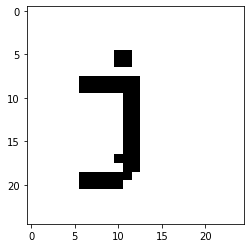

torch.Size([25, 25])


In [17]:
import matplotlib.pyplot as plt
a = training_image[3][0].reshape(25,25) #显示图片
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(a , cmap='gray')
plt.show()
print(a.shape)